In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/uist1/OneDrive/Desktop/Portfolio Work/Python Projects/HR Burnout/synthetic_employee_burnout.csv')

In [3]:
df.head(10)

,Name,Age,Gender,JobRole,Experience,WorkHoursPerWeek,RemoteRatio,SatisfactionLevel,StressLevel,Burnout
0,Max Ivanov,32,Male,Analyst,3,60,21,4.40,1,0
1,Max Wang,40,Female,Engineer,9,47,67,2.09,2,0
2,Nina Petrov,33,Female,Engineer,2,44,20,2.58,3,0
3,John Ivanov,35,Female,Manager,6,44,70,3.23,8,0
4,John Wang,59,Male,Sales,8,38,46,4.41,1,0
5,Lily Smith,45,Female,Sales,11,44,90,4.31,7,0
6,Max Garcia,31,Male,Sales,5,70,30,2.18,3,0
7,Ivan Chen,39,Female,HR,17,31,53,3.95,4,0
8,Kate Johnson,24,Male,Analyst,0,63,35,1.32,5,0
9,Lily Wang,22,Male,Engineer,1,30,5,1.44,5,0


## Summary Descriptives

In [5]:
df.describe()

,Age,Experience,WorkHoursPerWeek,RemoteRatio,SatisfactionLevel,StressLevel,Burnout
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,40.694500,10.074500,49.588000,49.973000,2.995230,5.43200,0.064500
std,11.286756,9.148267,11.832424,29.151298,1.155431,2.88089,0.245703
min,22.000000,0.000000,30.000000,0.000000,1.000000,1.00000,0.000000
25%,31.000000,3.000000,39.000000,24.000000,2.000000,3.00000,0.000000
50%,41.000000,7.000000,49.000000,49.000000,3.025000,5.00000,0.000000
75%,50.000000,15.000000,60.000000,75.000000,4.000000,8.00000,0.000000
max,60.000000,39.000000,70.000000,100.000000,5.000000,10.00000,1.000000


Initial examination of dataset reveals several surface level observations

1. Remote ratio is the percentage of job role which is delivered in a remote setting
2. Satisfaction is measured on a scale of one to five (assuming five is the most satisfied)
3. Stress is measured on a one to ten scale (ten being the most stressed)
4. Burnout is binary, with zero classified as participant not burnout and one classified as participant is suffering from burnout

## Demographic Descriptives

,Count
Gender,
Female,977
Male,1023


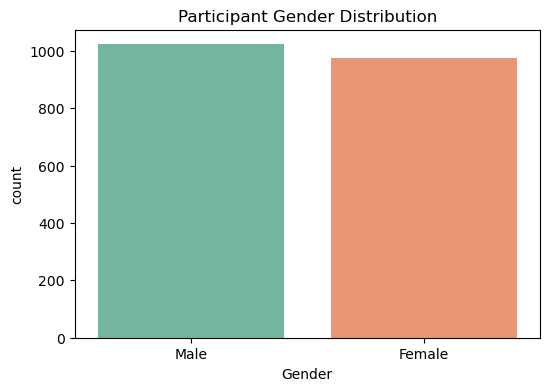

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Gender', palette='Set2').set_title('Participant Gender Distribution')

pd.DataFrame(df.groupby(by='Gender')['Gender'].count()).rename(columns={'Gender': 'Count'})


Text(0.5, 1.0, 'Participant Age Distribution')

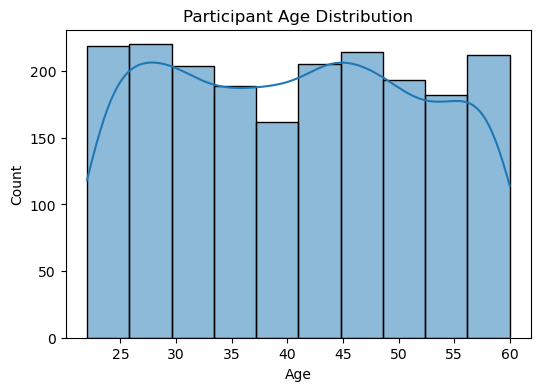

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Age', kde=True, bins=10).set_title('Participant Age Distribution')

Text(0.5, 1.0, 'Participant Age Distribution by Gender')

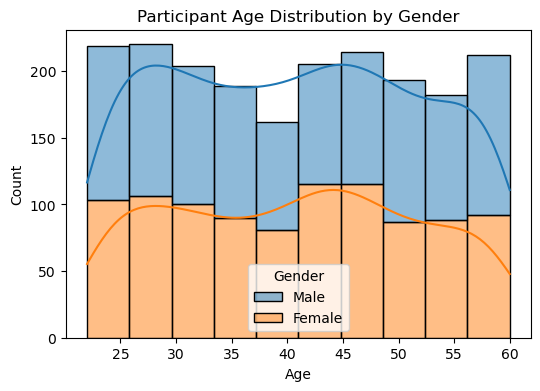

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Age', kde=True, bins=10, hue='Gender', multiple='stack').set_title('Participant Age Distribution by Gender')

Text(0.5, 1.0, 'Participant Age Boxplot')

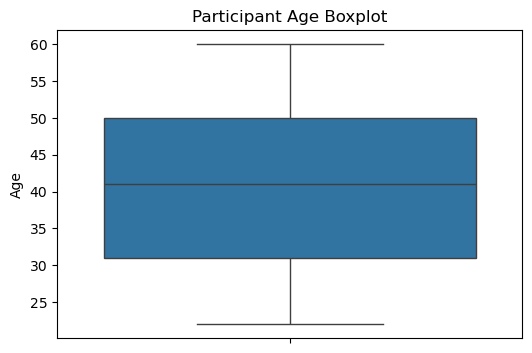

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, y='Age').set_title('Participant Age Boxplot')

Text(0.5, 1.0, 'Participant Age Boxplot')

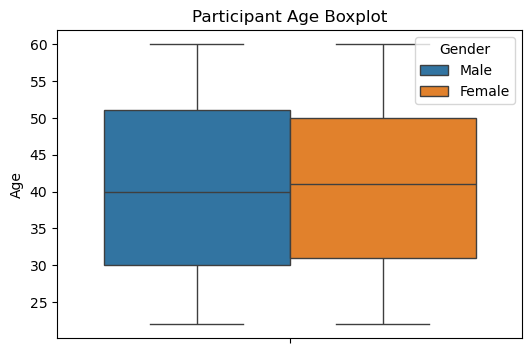

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, y='Age', hue='Gender').set_title('Participant Age Boxplot')

Examination of participant demographic data reveals the following:

1. Gender is relatively even in distribution amongst participants
2. Participant Age is not normally distributed, with relatively uniform distribution being observed
3. Participant Age distribution is equally as uniform across both participant Genders
4. Participant Age contains no observable outliers, both as a whole and when accounting for Gender

## Variable Descriptives

,Count
JobRole,
Analyst,413
Engineer,386
HR,391
Manager,419
Sales,391


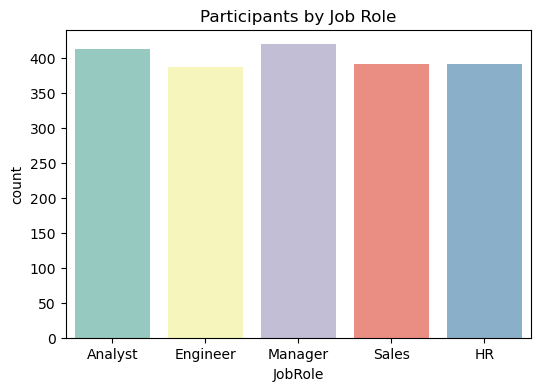

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='JobRole', palette='Set3').set_title('Participants by Job Role')

pd.DataFrame(df.groupby(by='JobRole')['JobRole'].count()).rename(columns={'JobRole': 'Count'})

Gender,Female,Male
JobRole,,
Analyst,182,231
Engineer,192,194
HR,210,181
Manager,211,208
Sales,182,209


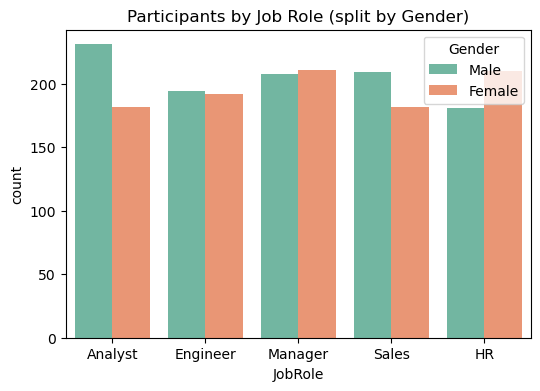

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='JobRole', palette='Set2',hue='Gender').set_title('Participants by Job Role (split by Gender)')

pd.pivot_table(df, values='Name', index=['JobRole'], columns='Gender', aggfunc="count")

Text(0.5, 1.0, 'Experience Distribution (Split by Gender)')

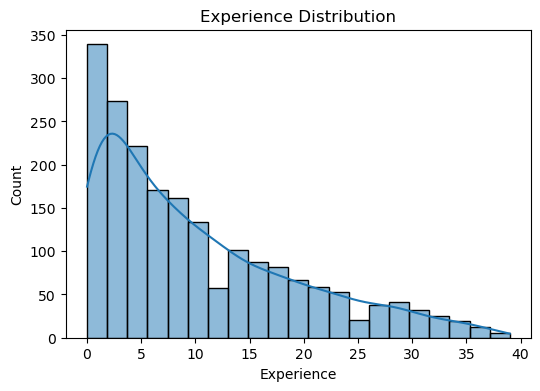

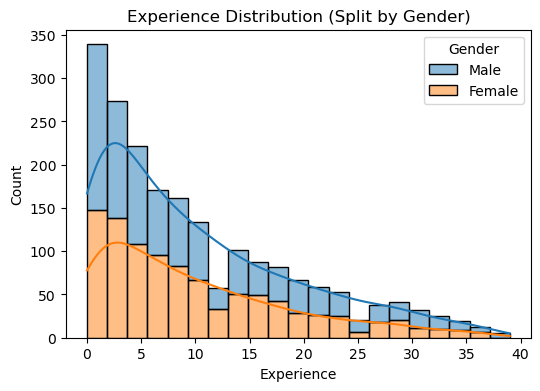

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Experience', kde=True).set_title('Experience Distribution')

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Experience', kde=True, hue='Gender', multiple='stack').set_title('Experience Distribution (Split by Gender)')


Text(0.5, 1.0, 'Work Hours Distribution (Split by Gender)')

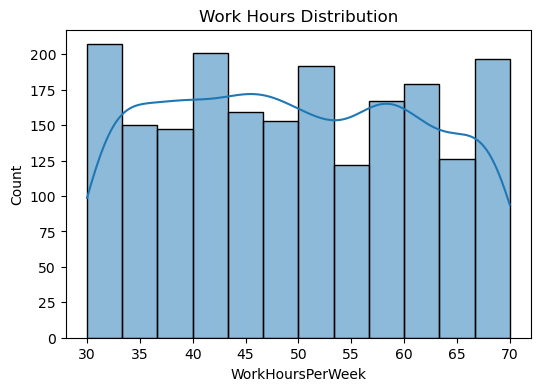

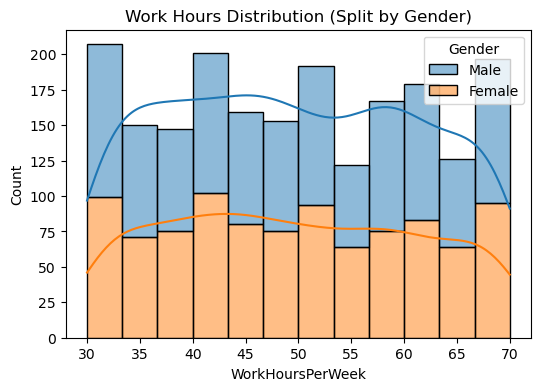

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='WorkHoursPerWeek', kde=True).set_title('Work Hours Distribution')

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='WorkHoursPerWeek', kde=True, hue='Gender', multiple='stack').set_title('Work Hours Distribution (Split by Gender)')


Text(0.5, 1.0, 'Participant Remote Ratio Distribution')

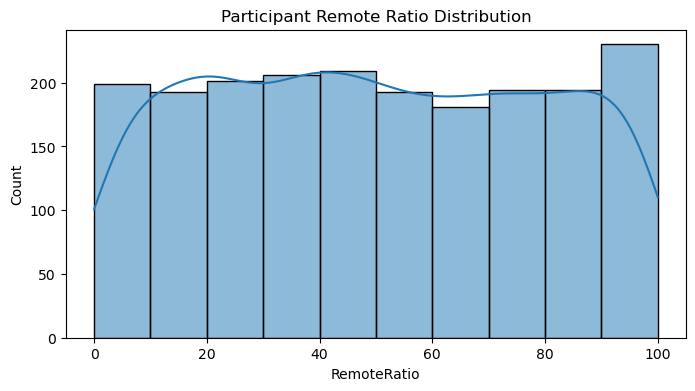

In [19]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='RemoteRatio', bins=10,kde=True).set_title('Participant Remote Ratio Distribution')

Text(0.5, 1.0, 'Participant Satisfaction Distribution')

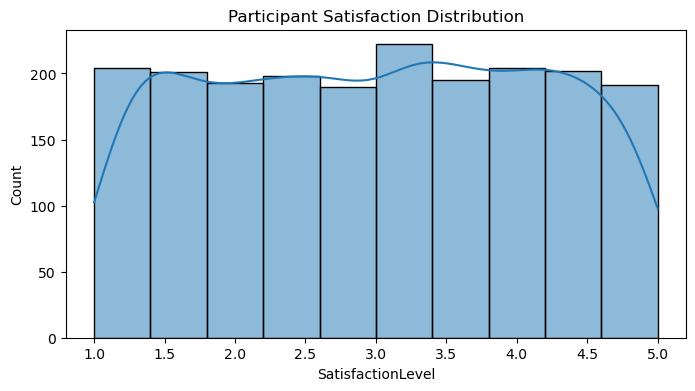

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='SatisfactionLevel', bins=10,kde=True).set_title('Participant Satisfaction Distribution')

Text(0.5, 1.0, 'Participant Stress Level Distribution (split by Gender)')

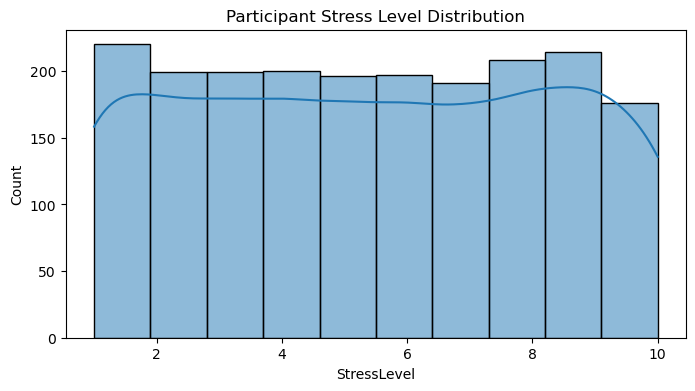

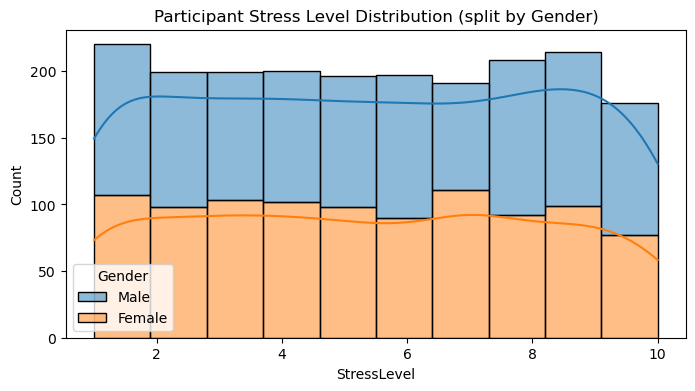

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='StressLevel', bins=10,kde=True).set_title('Participant Stress Level Distribution')

plt.figure(figsize=(8,4))
sns.histplot(data=df, x='StressLevel', hue='Gender', bins=10,kde=True, multiple='stack').set_title('Participant Stress Level Distribution (split by Gender)')

Examining distribution of the other variables revealed the following:

1. Participant distribution amongst job role is relatively even, with slightly more Male participants being observed in the analyst category and slightly more Female participants being observed in HR.
2. A right skew is displayed in the distribution of experience (number of years). Experience distribution is largely evenly split between Genders
3. Work hours distribution is multimodal, with peaks appearing typically at 5 hour intervals
4. Remote working ratio is uniformly distributed amongst participants, with a marginal peak at 100%
5. Both Stress Level and Satisfaction ratings are uniformly distributed, with the only exception being a drop off of stress level at the rating of 10

## Target Variable Descriptives

Text(0.5, 1.0, 'Burnout Count Across All Participants')

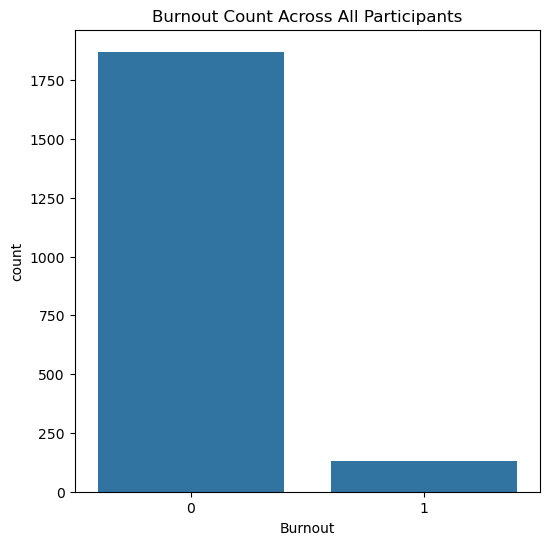

In [24]:
plt.figure(figsize=(6,6))
sns.countplot(data=df, x='Burnout').set_title('Reported Burnout Count Across All Participants')

Gender,Female,Male
JobRole,,
Analyst,10,10
Engineer,8,17
HR,16,10
Manager,15,13
Sales,12,18


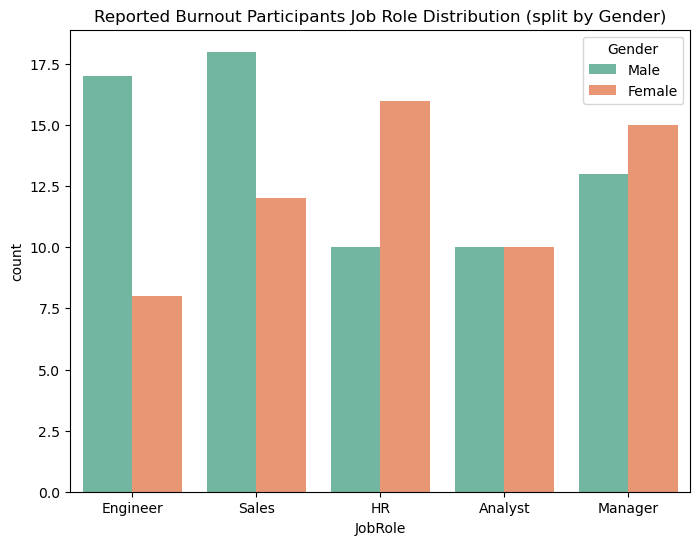

In [25]:
burnout_participants = df[df['Burnout'] == 1]
plt.figure(figsize=(8,6))
(sns.countplot(burnout_participants, x='JobRole',hue='Gender', palette='Set2').
 set_title('Reported Burnout Participants Job Role Distribution (split by Gender)'))

pd.DataFrame(pd.pivot_table(burnout_participants, values='Name', index=['JobRole'], columns='Gender', aggfunc="count"))


Text(0.5, 1.0, 'Reported Burnout Participants Experience Distribution (split by Gender)')

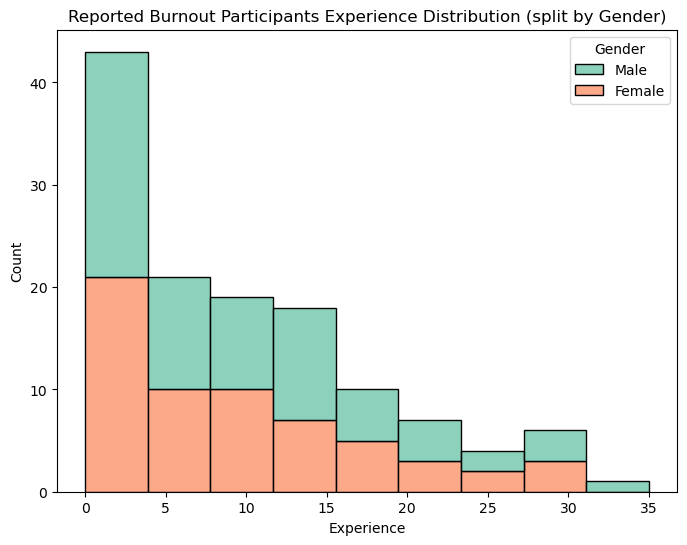

In [26]:
plt.figure(figsize=(8,6))
(sns.histplot(burnout_participants, x='Experience',hue='Gender', multiple='stack', palette='Set2').
 set_title('Reported Burnout Participants Experience Distribution (split by Gender)'))

## Variable Correlation 

In [28]:
#As Gender is binary but not numeric, dummy classes need creating for this variable. 
#Job Role can also be used as a classifier so dummy classes also need creating.

df_dummies = pd.get_dummies(df, columns = ['Gender'], drop_first=True, dtype=int)
df_dummies = pd.get_dummies(df, columns = ['JobRole'], drop_first=False, dtype=int)
df_dummies.drop(columns={'Name', 'Gender'}, inplace =True)

Text(0.5, 1.0, 'Correlation Matrix of Variables')

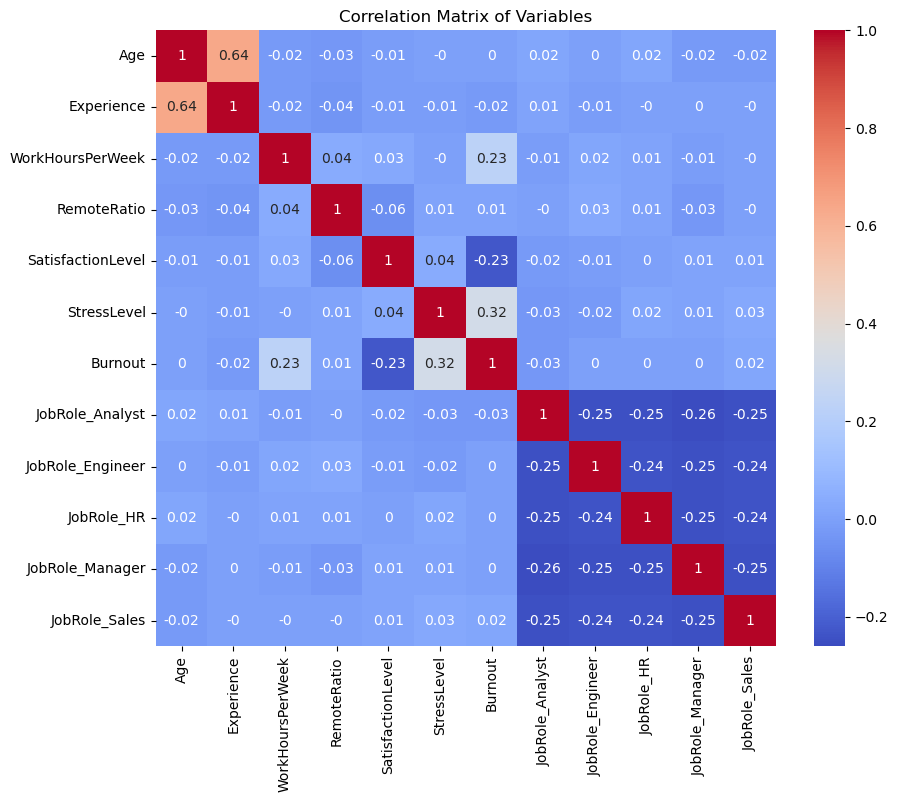

In [30]:
#Correlation Heatmap to explore relationship between variables
Correlation = df_dummies.corr().round(2)
#Display in heatmap
plt.figure(figsize=(10,8))
sns.heatmap(Correlation, annot=True, cmap='coolwarm').set_title('Correlation Matrix of Variables')

Correlation Matrix reveals only three variables showing any noteworthy correlation with burnout:

* Stress Level
* Satisfaction Level
* Work Hours Per Week

Text(0.5, 1.0, 'Regression Plot Satisfaction Level/Burnout')

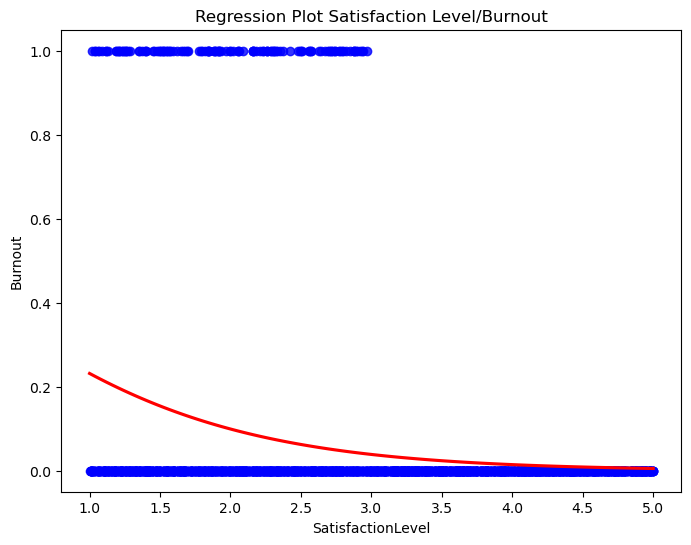

In [32]:
plt.figure(figsize=(8,6))
(sns.regplot(data=df_dummies, y='Burnout', x= 'SatisfactionLevel', logistic=True, ci=None,
             scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}).set_title('Regression Plot Satisfaction Level/Burnout'))

Text(0.5, 1.0, 'Regression Plot Stress Level/Burnout')

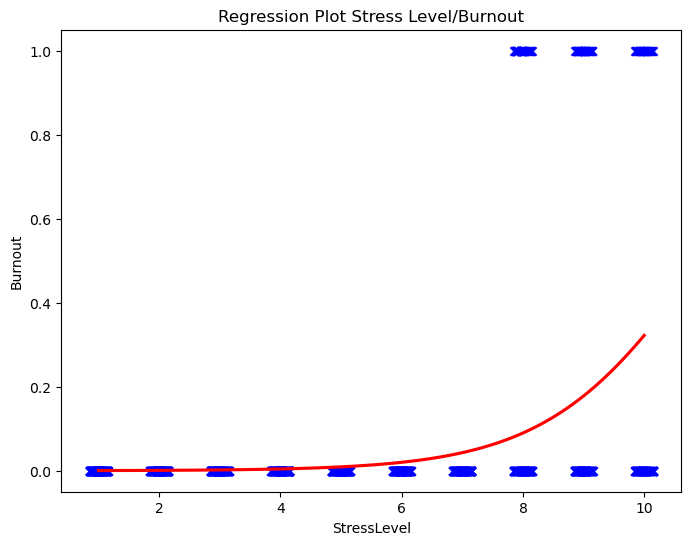

In [33]:
plt.figure(figsize=(8,6))
(sns.regplot(data=df_dummies, y='Burnout', x= 'StressLevel', logistic=True, ci=None, x_jitter=.15, marker='x',
             scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}).set_title('Regression Plot Stress Level/Burnout'))

Text(0.5, 1.0, 'Regression Work Hours/Burnout')

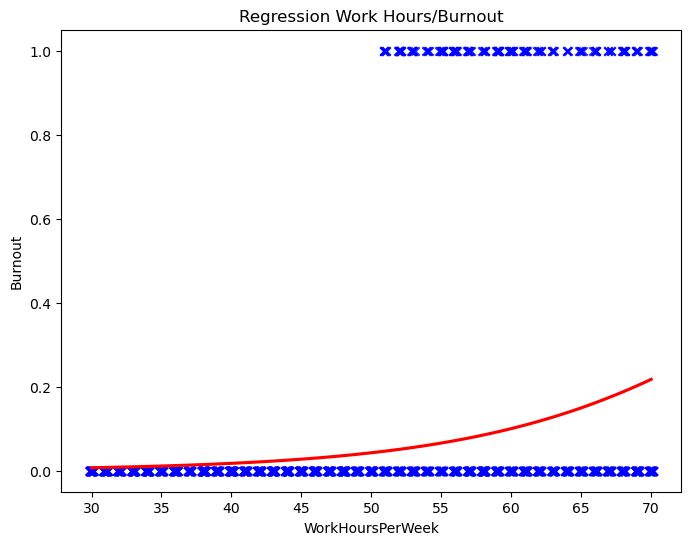

In [34]:
plt.figure(figsize=(8,6))
(sns.regplot(data=df_dummies, y='Burnout', x= 'WorkHoursPerWeek', logistic=True, ci=None, x_jitter=.15, marker='x',
             scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}).set_title('Regression Work Hours/Burnout'))

All three Reg plots do not demonstrate a classic "S" shaped sigmoid curve. Although it does reveal some interesting observations:

* No participants with a satisfaction score above 3 reported burnout
* No participants with a reported stress level below 8 also reported burnout
* No participants working less than 50 hours per week reported burnout

In the context of each variables relationship, the next step is to establish if any of the relationships demonstrate statistical significance

From earlier EDA we know the following:

* Stress Level and Satisfaction ratings are uniformly distributed
* Working hours per week has Multimodal distribution

Based on the fact that the data is not normally distributed, and one of the variables is categorical, Spearmens is the safest and most robust test to use to investigate if the relationship between these variables and burnout is statistically significant

In [36]:
Variable_Pairs = [
    ('Burnout', 'WorkHoursPerWeek'),
    ('Burnout', 'StressLevel'),
    ('Burnout' ,'SatisfactionLevel')
]
results = {}
for var1, var2 in Variable_Pairs:
    correlation, p_value = spearmanr(df[var1], df[var2])
    results[f'{var1} vs {var2}'] = {'Spearman Correlation': correlation, 'p_value': p_value}

for pair, results in results.items():
    print(f"{pair}: Spearman Correlation = {results['Spearman Correlation']:.3f}, p_value = {results['p_value']:.3f}")

Burnout vs WorkHoursPerWeek: Spearman Correlation = 0.226, p_value = 0.000
Burnout vs StressLevel: Spearman Correlation = 0.321, p_value = 0.000
Burnout vs SatisfactionLevel: Spearman Correlation = -0.232, p_value = 0.000


All three variables demonstrate alpha of <0.05 and the relationship can therefore be considered statistically significant. 

* Burnout vs WorkHoursPerWeek - Weak Relationship
* Burnout vs StressLevel: Spearman Correlation - Moderate Relationship
* Burnout vs SatisfactionLevel - Weak Relationship

As these variables all reach statistical significance these will all be used in a multiple regression model

## Logistic Regression Model

In [39]:
df_model = df_dummies.iloc[ : , [2, 4, 5 , 6]]

In [40]:
x = df_model[['WorkHoursPerWeek', 'SatisfactionLevel', 'StressLevel']]
y = df_model[['Burnout']]

#Training split of 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [41]:
reg_model = LogisticRegression()
reg_model.fit(x_train, y_train)

LogisticRegression()

In [42]:
y_pred = reg_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy Score: {:.2f}%'.format(accuracy * 100))
print('F1 Score :' f'{f1}')

Accuracy Score: 94.75%
F1 Score :0.5333333333333333


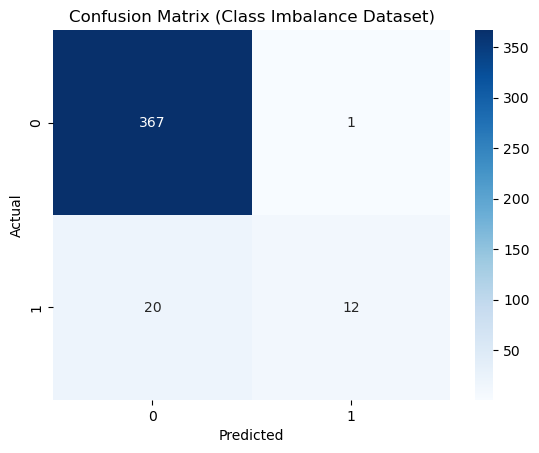

In [43]:
cm= confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Class Imbalance Dataset)')
plt.show()

Despite 94% accuracy the poor F1 score indicates the model struggles with balancing recall and precision. Initial EDA revealed significant class imbalance in the target variable. The next step is to apply a resampling technique, retrain the model and measure performance

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

sm = SMOTE(random_state=42, sampling_strategy='minority')
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

In [46]:
scaler = StandardScaler()
x_train_smote = scaler.fit_transform(x_train_smote)
x_test = scaler.transform(x_test)

In [47]:
y_train_smote.value_counts()

Burnout
0          1503
1          1503
Name: count, dtype: int64

In [48]:
logreg = LogisticRegression()
logreg.fit(x_train_smote, y_train_smote)

LogisticRegression()

In [49]:
y_pred = logreg.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy Score: {:.2f}%'.format(accuracy * 100))
print('F1 Score :' f'{f1}')
print(classification_report(y_test, y_pred))

Accuracy Score: 94.50%
F1 Score :0.7441860465116279
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       368
           1       0.59      1.00      0.74        32

    accuracy                           0.94       400
   macro avg       0.80      0.97      0.86       400
weighted avg       0.97      0.94      0.95       400



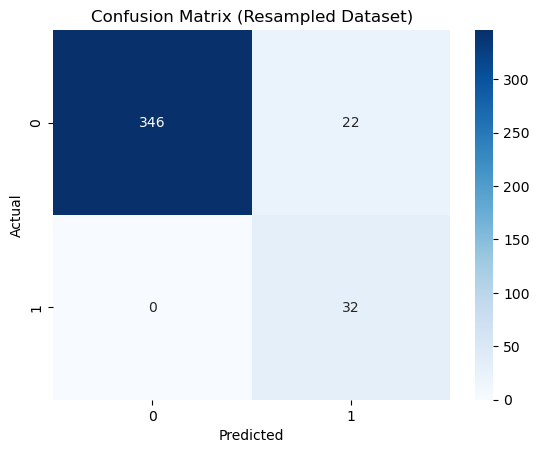

In [50]:
cm= confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Resampled Dataset)')
plt.show()

After applying the Smote re-sampling, the F-1 Score has increased significantly with the model correctly predicting a large volume of both classes of the target variable. Some false positives remain, with the model incorrectly predicting Burnout in participants that did not report Burnout. 

The next step is to modify the logistic regression model to Random Forest as this model is known to handle datasets with class imbalance well and measure performance

## Random Forest 

In [53]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42
    ))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_rf = cross_val_predict(rf_pipeline, x, y, cv=cv)


f1_rf = f1_score(y, y_pred_rf)
accuracy_rf = accuracy_score(y, y_pred_rf)
rmse_rf = mean_squared_error(y, y_pred_rf, squared=False)

print("\nRandom Forest Metrics:")
print(f"F1 Score    : {f1_rf:.4f}")
print(f"Accuracy    : {accuracy_rf:.4f}")
print(f"RMSE        : {rmse_rf:.4f}")


Random Forest Metrics:
F1 Score    : 0.9961
Accuracy    : 0.9995
RMSE        : 0.0224


In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

rf_pipeline.fit(x_train, y_train)

# Predict on test data
y_test_pred = rf_pipeline.predict(x_test)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00        26

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



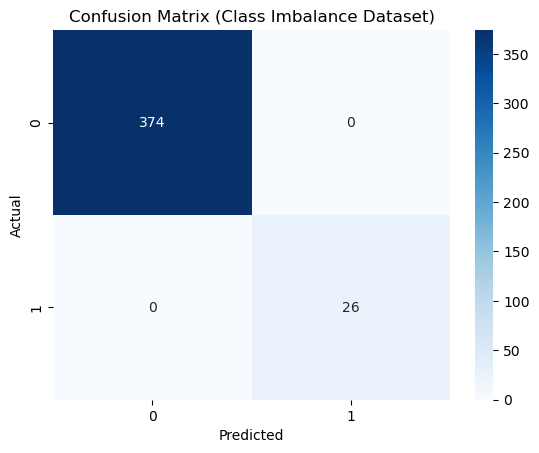

In [55]:
cm= confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Class Imbalance Dataset)')
plt.show()

After deploying the Random Forest Model F1 score is 99%. Accuracy also display's 99% with the confusion matrix demonstrating all predictions made by the model to be correct. 

In [57]:
rf_model = rf_pipeline.named_steps['model']

importances = rf_model.feature_importances_

feature_importance = pd.Series(importances, index=x.columns)

output = pd.DataFrame(feature_importance).reset_index().rename(columns={'index' : 'Variable', 0 : 'Importance'})

Text(0.5, 1.0, 'Feature Importance of Predictor Variables')

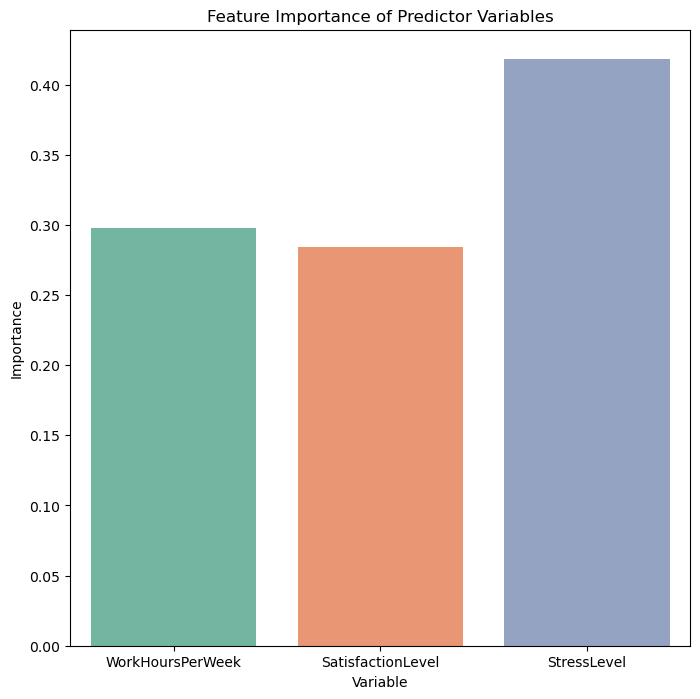

In [58]:
plt.figure(figsize=(8,8))
(sns.barplot(data=output, x='Variable', y='Importance', palette='Set2').set_title
 ('Feature Importance of Predictor Variables'))